importing needed libraries

In [2]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OWNER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

## preprocessing the dataset

In [4]:
df = pd.read_csv('TeePublic_review.csv', encoding='ISO-8859-1')
df.head()

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,0.0,US,37.090240,-95.712891,2023,6,2015 00:00:00,Great help with lost order,I had an order that was lost in transit. When ...,5
1,1.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,I ordered the wrong size tee and hadï¿½ï¿½ï¿½,I ordered the wrong size tee and had difficult...,5
2,2.0,US,37.090240,-95.712891,2023,6,2017 00:00:00,These guys offer the best customerï¿½ï¿½ï¿½,These guys offer the best customer service in ...,5
3,3.0,US,37.090240,-95.712891,2023,6,2024 00:00:00,Good Stuff,Looked for an obscure phrase on a shirt. Teepu...,5
4,4.0,CA,56.130366,-106.346771,2023,6,2023 00:00:00,My order arrived in a good timelyï¿½ï¿½ï¿½,My order arrived in a good timely fashion & th...,4


<Axes: >

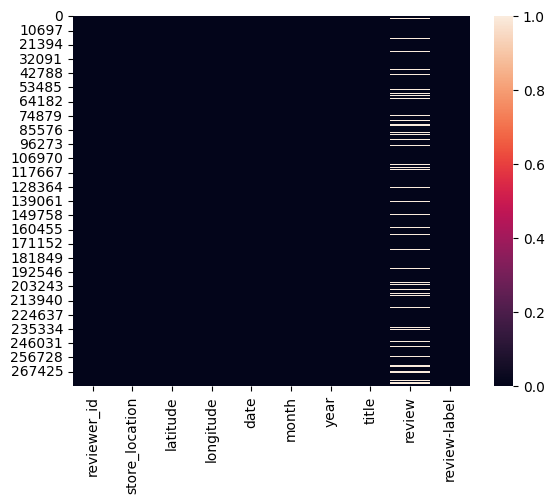

In [4]:
sns.heatmap(df.isnull())

In [5]:
df.dropna(inplace=True)

<Axes: xlabel='review-label', ylabel='count'>

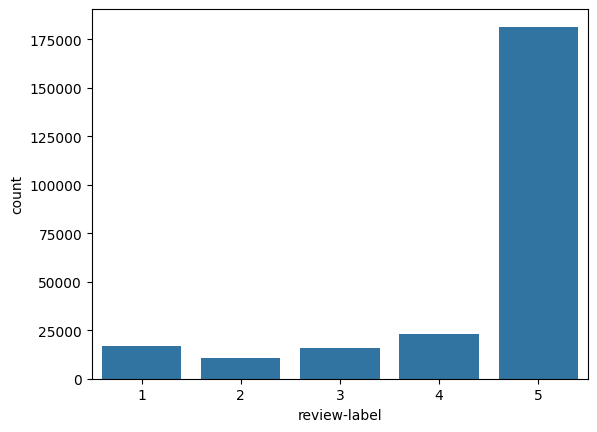

In [38]:
sns.countplot(x='review-label', data=df)

In [6]:
min_count = df['review-label'].value_counts().min()
balanced_df = pd.DataFrame()

for i in range(1,6):
    balanced_df = pd.concat([balanced_df, df[df['review-label'] == i].sample(n=min_count, random_state=42)], axis=0)



<Axes: xlabel='review-label', ylabel='count'>

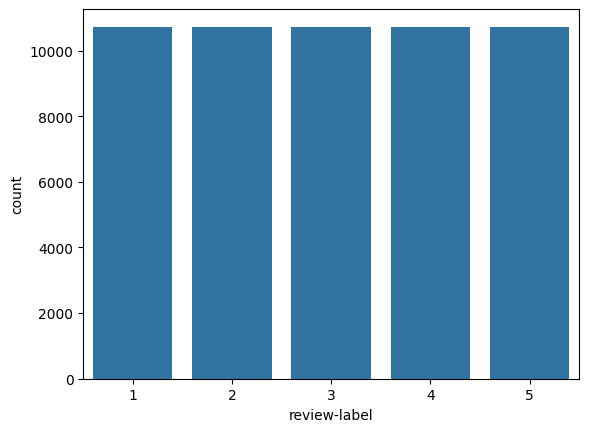

In [40]:
sns.countplot(x='review-label', data=balanced_df)

stemming the text

eg.: saying ====> say

In [7]:
neg_words =['not','don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",  'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", "won't", 'wouldn', "wouldn't"]
english_stopwords = [x for x in stopwords.words('english') if x not in neg_words]
len(english_stopwords)

142

In [49]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [porterstemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [48]:
porterstemmer = PorterStemmer()

In [50]:
balanced_df['review'] = balanced_df['review'].apply(stemming)

In [59]:
def remove_non_ascii(text):
    if isinstance(text, str):  # Check if the input is a string
        return text.encode('ascii', 'ignore').decode('ascii')
    else:
        return text  # Return the original value if it's not a string (e.g., float)



In [60]:
balanced_df['review'] = balanced_df['review'].apply(remove_non_ascii)

In [51]:
balanced_df.dropna(inplace=True)

In [61]:
#save the balanced preprocessed dataset
balanced_df.to_csv('balanced_df.csv', index=False)

Using the review column as  input and the review-label as the target output

In [3]:
balanced_df = pd.read_csv('balanced_df.csv')
balanced_df.head()

,reviewer_id,store_location,latitude,longitude,date,month,year,title,review,review-label
0,151782.0,US,37.09024,-95.712891,2021,6,2008 00:00:00,I like the tee shirt I ordered butï¿½ï¿½ï¿½ï¿½...,like tee shirt order truth qualiti shirt self ...,1
1,27155.0,US,37.09024,-95.712891,2023,1,2001 00:00:00,Poor quality and smelled bad,order two differ item differ vendor shirt chea...,1
2,72707.0,US,37.09024,-95.712891,2022,8,2007 00:00:00,I did not get my complete order,get complet order im miss mask,1
3,2766.0,US,37.09024,-95.712891,2023,6,2010 00:00:00,I never received the shirt I orderedï¿½ï¿½ï¿½,never receiv shirt order get touch anyon,1
4,240808.0,US,37.09024,-95.712891,2019,9,2028 00:00:00,"Too small, poor quality",normal xl order xl could put long sleev shirt ...,1


In [4]:
balanced_df.dropna(inplace=True)

In [5]:
X  = balanced_df['review']
Y = balanced_df['review-label']-1

In [7]:
balanced_df['len'] = balanced_df['review'].str.len()

<Axes: xlabel='review-label', ylabel='len'>

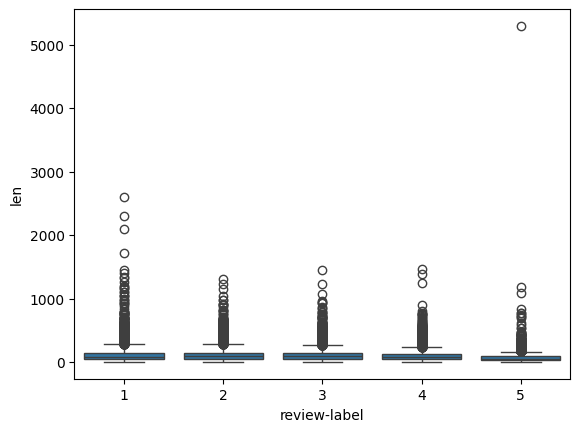

In [12]:
sns.boxplot(x='review-label', y='len', data=balanced_df)


vecotrize the input review

In [11]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

cross-validation

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Using logistic regression to predict the label

In [45]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[
    ('lrc',LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0)),
    ('xgb', XGBClassifier())], voting='soft')



c:\Users\OWNER\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:20:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('lrc',
                              LogisticRegression(l1_ratio=0.5,
                                                 penalty='elasticnet',
                                                 solver='saga')),
                             ('xgb',
                              XGBClassifier(alpha=0.1, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            lambda_=1.0, learning_rate=0.01,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None, ...))],
                 voting='soft')

In [52]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'min_child_weight': [1, 2]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                   scoring='accuracy', n_iter=10, cv=3, verbose=1, random_state=42)

# Fit the randomized search to the data
random_search.fit(x_train, y_train)

In [ ]:
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Use the best estimator to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Output the classification report
print(classification_report(y_test, y_pred))

In [60]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[
    ('lrc',LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0)),
    ('xgb', XGBClassifier())], voting='soft')

model.fit

c:\Users\OWNER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100, random_state=42)

In [64]:
param_dist = {
    'lrc__C': [0.01, 0.1, 1, 10, 100],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
}

In [65]:

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_dist, 
                                   n_iter=10, 
                                   cv=3, 
                                   scoring='accuracy', 
                                   verbose=1, 
                                   random_state=42)

# Fit the randomized search to the data
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\OWNER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\OWNER\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:49:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\OWNER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\OWNER\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src

RandomizedSearchCV(cv=3,
                   estimator=VotingClassifier(estimators=[('lrc',
                                                           LogisticRegression(l1_ratio=0.5,
                                                                              penalty='elasticnet',
                                                                              solver='saga')),
                                                          ('xgb',
                                                           XGBClassifier(alpha=0.1,
                                                                         base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         device=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_...
                                                                         max_cat_to_onehot=None,
                                                                         max_delta_step=None,
                                                                         max_depth=3,
                                                                         max_leaves=None,
                                                                         min_child_weight=1,
                                                                         missing=nan,
                                                                         monotone_constraints=None,
                                                                         multi_strategy=None,
                                                                         n_estimators=100,
                                                                         n_jobs=None, ...))],
                                              voting='soft'),
                   param_distributions={'lrc__C': [0.01, 0.1, 1, 10, 100],
                                        'xgb__learning_rate': [0.01, 0.1, 0.2],
                                        'xgb__n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy', verbose=1)

In [66]:

# Get the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)

# Make predictions with the best model
val_pred = best_model.predict(x_val)

# Evaluate the model
accuracy = accuracy_score(y_val, val_pred)
print(f"Accuracy: {accuracy:.4f}")

Best Parameters: {'xgb__n_estimators': 200, 'xgb__learning_rate': 0.2, 'lrc__C': 1}
Accuracy: 0.5409


results of the logistic model

In [62]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.46      0.57      0.51      6838
           1       0.40      0.40      0.40      6915
           2       0.37      0.29      0.32      6801
           3       0.49      0.43      0.46      6869
           4       0.66      0.75      0.70      6905

    accuracy                           0.49     34328
   macro avg       0.48      0.49      0.48     34328
weighted avg       0.48      0.49      0.48     34328



              precision    recall  f1-score   support

           0       0.62      0.70      0.66      6838
           1       0.51      0.48      0.50      6915
           2       0.52      0.47      0.50      6801
           3       0.61      0.56      0.58      6869
           4       0.76      0.84      0.80      6905

    accuracy                           0.61     34328
   macro avg       0.61      0.61      0.61     34328
weighted avg       0.61      0.61      0.61     34328

In [63]:
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       0.45      0.53      0.48      1744
           1       0.37      0.39      0.38      1668
           2       0.39      0.29      0.34      1781
           3       0.49      0.44      0.46      1713
           4       0.65      0.74      0.69      1676

    accuracy                           0.48      8582
   macro avg       0.47      0.48      0.47      8582
weighted avg       0.47      0.48      0.47      8582




              precision    recall  f1-score   support

           1       0.58      0.64      0.61      3219
           2       0.43      0.41      0.42      3218
           3       0.44      0.39      0.42      3219
           4       0.56      0.52      0.54      3218
           5       0.73      0.83      0.78      3218

    accuracy                           0.56     16092
   macro avg       0.55      0.56      0.55     16092
weighted avg       0.55      0.56      0.55     16092

<Axes: >

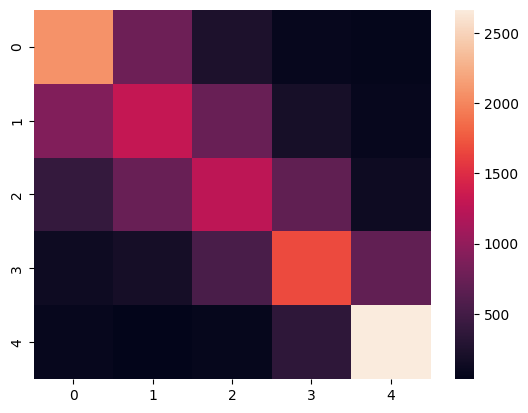

In [18]:
sns.heatmap(confusion_matrix(y_test, val_pred) )

In [17]:
misclassified_indices = (val_pred != y_test)

In [19]:
misclassified_samples = pd.DataFrame({
    'Actual': y_test[misclassified_indices],
    'Predicted': val_pred[misclassified_indices],

})

In [38]:
misclassified_samples['difference'] = abs(misclassified_samples["Actual"] -misclassified_samples["Predicted"])
counts = misclassified_samples['difference'].value_counts()
prob = counts /len(misclassified_samples['difference'])
prob

difference
1    0.762673
2    0.171529
3    0.045727
4    0.020070
Name: count, dtype: float64

([<matplotlib.patches.Wedge at 0x26ba1372650>,
 [Text(0.8081610654300267, -0.7462410417036872, '1'),
  Text(-0.6377976559746164, 0.8962221543977169, '2'),
  Text(-1.060217655837847, 0.2931527285387272, '3'),
  Text(-1.0978140955748674, 0.0693124199342091, '4')],
 [Text(0.4408151265981964, -0.4070405682020112, '76.3%'),
  Text(-0.3478896305316089, 0.48884844785330006, '17.2%'),
  Text(-0.5783005395479165, 0.1599014882938512, '4.6%'),
  Text(-0.5988076884953821, 0.03780677450956859, '2.0%')])

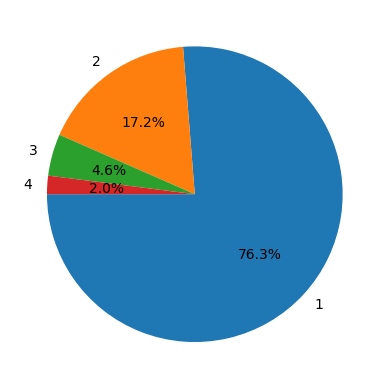

In [33]:
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=180)

In [24]:
misclassified_samples.head(20)

,Actual,Predicted,difference
39414,3,2,1
15770,1,0,1
42968,4,3,1
2139,0,1,1
12607,1,2,1
2427,0,1,1
26225,2,1,1
33327,3,2,1
29802,2,4,2
30886,2,3,1


In [17]:
def take_output(input_text):
    text = stemming(input_text)
    vector = vectorizer.transform([text])
    prediction = logistic_model.predict(vector)
    print(prediction)